In [6]:
import array

import random
import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import operator
import math

import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

import networkx as nx

In [7]:
from inspect import isclass
import random

def generate(pset, min_, max_, condition, type_=None):
    """Generate a Tree as a list of list. The tree is build
    from the root to the leaves, and it stop growing when the
    condition is fulfilled.

    :param pset: Primitive set from which primitives are selected.
    :param min_: Minimum height of the produced trees.
    :param max_: Maximum Height of the produced trees.
    :param condition: The condition is a function that takes two arguments,
                      the height of the tree to build and the current
                      depth in the tree.
    :param type_: The type that should return the tree when called, when
                  :obj:`None` (default) the type of :pset: (pset.ret)
                  is assumed.
    :returns: A grown tree with leaves at possibly different depths
              dependending on the condition function.
    """
    if type_ is None:
        type_ = pset.ret
    expr = []
    height = random.randint(min_, max_)
    stack = [(0, type_)]
    while len(stack) != 0:
        depth, type_ = stack.pop()
        if condition(height, depth):
            try:
                term = random.choice(pset.terminals[type_])
            except IndexError:
                _, _, traceback = sys.exc_info()
                raise IndexError, "The gp.generate function tried to add "\
                                  "a terminal of type '%s', but there is "\
                                  "none available." % (type_,), traceback
            if isclass(term):
                term = term()
            expr.append(term)
        elif pset.primitives[type_]:
            try:
                prim = random.choice(pset.primitives[type_])
            except IndexError:
                _, _, traceback = sys.exc_info()
                raise IndexError, "The gp.generate function tried to add "\
                                  "a primitive of type '%s', but there is "\
                                  "none available." % (type_,), traceback
            expr.append(prim)
            for arg in reversed(prim.args):
                stack.append((depth + 1, arg))
        else:
            try:
                term = random.choice(pset.terminals[type_])
            except IndexError:
                _, _, traceback = sys.exc_info()
                raise IndexError, "The gp.generate function tried to add "\
                                  "a terminal of type '%s', but there is "\
                                  "none available." % (type_,), traceback
            if isclass(term):
                term = term()
            expr.append(term)
    return expr

gp.generate = generate

In [8]:
def draw_tree(expr):
    nodes, edges, labels = gp.graph(expr)
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = graphviz_layout(g, prog="dot")

    nx.draw_networkx_nodes(g, pos)
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels)
    plt.show()

In [9]:
def char_range(c1, c2):
    """Generates the characters from `c1` to `c2`, inclusive."""
    for c in xrange(ord(c1), ord(c2)+1):
        yield chr(c)

In [10]:

class RegexNode(object):
    index = 0
    def __init__(self, template="{0}"):
        self.children = []
        self.template = template
        self.index = RegexNode.index
        RegexNode.index += 1
        
    @property
    def regex(self):
        value = "".join([child.regex for child in self.children])
        return self.template.format(value)
    
    @staticmethod
    def empty():
        node = RegexNode()
        return node

    
class Factory(object):
    @staticmethod
    def create_star_quantifier(child):
        node = RegexNode(template = "(?:{0})*")
        node.children = [child]
        return node

    @staticmethod
    def create_question_mark_quantifier(child):
        node = RegexNode(template = "(?:{0})?")
        node.children = [child]
        return node
    
    @staticmethod
    def create_plus_quantifier(child):
        node = RegexNode(template = "(?:{0})+")
        node.children = [child]
        return node
        
    @staticmethod
    def create_group(child):
        node = RegexNode(template = "(?:{0})")
        node.children = [child]
        return node
    
    @staticmethod
    def create_concatenator(child1, child2):
        node = RegexNode(template = "{0}")
        node.children = [child1, child2]
        return node
    
    @staticmethod
    def create_range(child):
        node = RegexNode(template = "[{0}]")
        node.children = [child]
        return node
        
    
class RegexTerminal(RegexNode):
    def __init__(self, value=""):
        self.value = value
    
    @property
    def regex(self):
        return self.value
    
    @staticmethod
    def create(value):
        return RegexTerminal(value=value)

    
    
class RangeTerminal(object):
    def __init__(self, value=""):
        self.value = value
    
    @property
    def regex(self):
        return self.value
    
    @staticmethod
    def create(value):
        return RegexTerminal(value=value)
        
    @staticmethod
    def empty():
        return RegexTerminal()

In [11]:
pset = gp.PrimitiveSetTyped("main", [], RegexNode)


for letter in char_range('a', 'z'):
    pset.addTerminal(RegexTerminal.create(letter), RegexTerminal, "l_" + letter)
    
for letter in char_range('A', 'Z'):
    pset.addTerminal(RegexTerminal.create(letter), RegexTerminal, "l_" + letter)
    
for digit in char_range('0', '9'):
    pset.addTerminal(RegexTerminal.create(digit), RegexTerminal, "d_" + digit)
    
for idx, symbol in enumerate(["!", "@", "#", "\$", "%", "\^", "&", "\*", "\(", "\)", "<", ">", "\[", "\]"]):
    pset.addTerminal(RegexTerminal.create(symbol), RegexTerminal, "s_" + str(idx))
    
pset.addTerminal(RegexTerminal.create(" "), RegexTerminal, "space")
    
#for idx, character_class in enumerate(["\w", "\u"]):
#    pset.addTerminal(RegexTerminal.create(character_class), RegexTerminal, "c_" + str(idx))
    
for idx, range_value in enumerate(["[A-Z]", "[a-z]", "[0-9]"]):
    pset.addTerminal(RangeTerminal.create(range_value), RegexTerminal, "r_" + str(idx))
    
for idx, symbol in enumerate(["[,.?!]"]):
    pset.addTerminal(RangeTerminal.create(symbol), RangeTerminal, "rs_" + str(idx))
    
#pset.addTerminal(RangeTerminal.create(" "), RangeTerminal, "rspace")
    

pset.addPrimitive(Factory.create_concatenator, [RegexNode, RegexNode], RegexNode, "Conc")
pset.addPrimitive(Factory.create_group, [RegexNode], RegexNode, "Group")
pset.addPrimitive(Factory.create_plus_quantifier, [RegexNode], RegexNode, "Plus")
pset.addPrimitive(Factory.create_question_mark_quantifier, [RegexNode], RegexNode, "QMark")
pset.addPrimitive(Factory.create_star_quantifier, [RegexNode], RegexNode, "Star")
#pset.addPrimitive(Factory.create_range, [RangeTerminal], RegexNode, "Range")
#pset.addPrimitive(Factory.create_concatenator, [RangeTerminal, RangeTerminal], RangeTerminal, "RangeConc")


In [12]:


creator.create("Fitness", base.Fitness, weights=(1.0, -1.0, -1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.Fitness)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=1, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

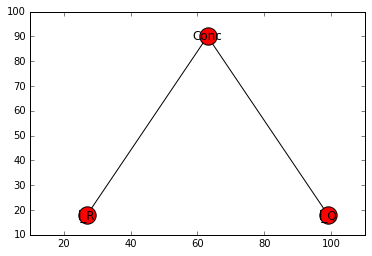

In [13]:
expr = toolbox.individual()

draw_tree(expr)

In [14]:
for _ in xrange(10):
    expr = toolbox.individual()
    print gp.compile(expr, pset).regex

(?:(?:(?:(?:p)?))?)*
(?:(?:(?:(?:(?:\[)*)+)+)?)
(?:(?:(?:E)+w\())
(?:\()+
(?:(?:(?:b))+)?
(?:Z)*
(?:(?:&)+)?
(?:(?:r\[)?)*
(?:(?:YC)+)+
(?:sX(?:L)(?:(?:g)*)*)?


In [ ]:
PERFECT_SCALE = 1.0

def sign(x):
    if x > 0:
        return 1.0
    if x < 0:
        return -1.0
    return 0.0

import re, sys
correct_testset = [
    "Ala ma kota a kot ma ale.",
    "Ja tam lubie jedzenie.",
    "Gdzie mamy sie podziac?",
    "Laboga kto nam pomoze?",
    "O boze co to jest!",
    "Kim jestes czlowieku?",
    "Tam jest zachod.",
    "Bardzo lubie jesc placki.",
    "Nie ma tego zlego co by na dobre nie wyszlo.",
    "Stoj!",
    "Po co ci to bylo?",
    "Jeszcze ze dwa zdania i konczymy.",
    "Tam zobacz!",
    "Koniec",
]
wrong_testset = [
    "Ala Ma Kota A Kot ma Ale.",
    "Nikt nie Lubi psow .",
    "Kto by tam chcial pojsc .",
    "Ja na Pewno Nie pojde do ?!",
    "a gdzie tam",
    "A! co ! ty tam !",
    " Gdzie ? ! no jak!?",
    " Co ty W ogole ! Mowisz do ! mnie",
    "mnie.mnei.mnie.mnie ",
    "Sprawdzam, jak? to si! zachowa!",
    "co ty mowisz nicponiu",
    "?co?",
    "Gdzie Tam ! ?",
    "Jeszcze wiecej zdan Testowych !",
    "Chyba duzo zdan POWINNO byc.",
    "TAKIcH ZDAN NIE AKCEPTUJEMY!",
    "NIE WOLNO KRZYCZEC",
    "??!!!",
    ".",
    "?",
    "!",
    "!No.",
]

def test_testset(regex, testset):
    total, partial, count = 0, 0, 0
    
    for test_item in testset:
        match = re.match(regex, test_item)
        if match:
            result = match.groups()[0]
            value = len(result) / float(len(test_item))
            if value == 1.0:
                total += 1
            partial += value
        count += 1.0

    if count == 0:
        return 0, 0
    return total / float(count), partial / float(count)
            

def evaluate(individual):
    tree = gp.PrimitiveTree(individual)
    regex = "({})".format(gp.compile(tree, pset).regex)
    #print regex, tree
    length = len(regex)
        
    correct, correct_partial = test_testset(regex, correct_testset)
    wrong, wrong_partial = test_testset(regex, wrong_testset)
    
    good = correct + correct_partial
    bad = wrong + wrong_partial
    return good, bad * 2, length

In [18]:
toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))

stats_correct = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_wrong = tools.Statistics(lambda ind: ind.fitness.values[1])
stats_size = tools.Statistics(len)

mstats = tools.MultiStatistics(stats_correct=stats_correct,
                               stats_wrong=stats_wrong,
                               stats_size=stats_size)
mstats.register("avg", np.mean)

In [19]:
NGEN = 30
pop = toolbox.population(n=3000)
hof = tools.HallOfFame(10)
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=NGEN, stats=mstats,
                               halloffame=hof, verbose=True)


   	      	stats_correct	stats_size	stats_wrong
   	      	---------    	-------   	---------  
gen	nevals	avg          	avg       	avg        
0  	3000  	0.0226904    	5.69833   	0.0387355  
1  	1751  	0.0493581    	4.36367   	0.0401901  
2  	1823  	0.107035     	4.48633   	0.0730246  
3  	1843  	0.214494     	4.95567   	0.136064   
4  	1811  	0.373021     	5.32667   	0.236587   
5  	1826  	0.573695     	5.449     	0.375556   
6  	1859  	0.703989     	5.062     	0.461696   
7  	1756  	0.788966     	4.69233   	0.486312   
8  	1799  	0.838987     	4.88767   	0.498541   
9  	1723  	0.946961     	5.948     	0.562064   
10 	1869  	1.18398      	7.64533   	0.69333    
11 	1824  	1.62682      	8.987     	0.907213   
12 	1796  	2.25093      	9.67633   	1.1897     
13 	1740  	2.87141      	10.078    	1.47554    
14 	1757  	3.19814      	10.1153   	1.62038    
15 	1794  	3.33545      	9.90233   	1.67298    
16 	1814  	3.31927      	9.56      	1.6256     
17 	1777  	3.27545      	9.25633   	1.56

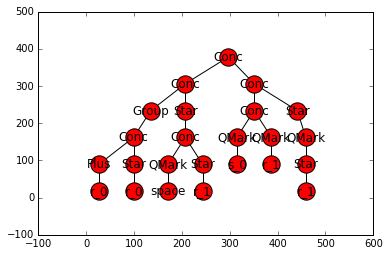

(?:(?:[A-Z])+(?:[A-Z])*)(?:(?: )?(?:[a-z])*)*(?:!)?(?:[a-z])?(?:(?:(?:[a-z])*)?)* (17.56363976816023, 4.286466776950649, 83)


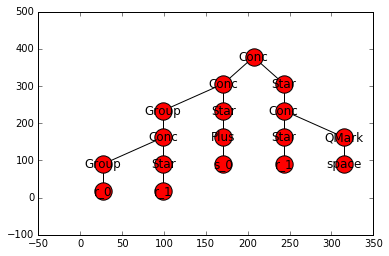

(?:(?:[A-Z])(?:[a-z])*)(?:(?:!)+)*(?:(?:[a-z])*(?: )?)* (15.41717512169558, 4.226942967426838, 57)


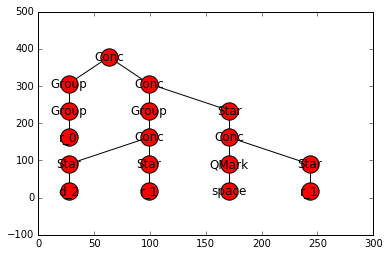

(?:(?:[A-Z]))(?:(?:2)*(?:[a-z])*)(?:(?: )?(?:[a-z])*)* (14.21717512169558, 3.9144429674268384, 56)


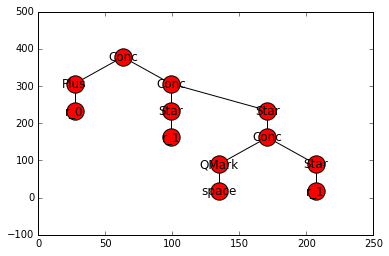

(?:[A-Z])+(?:[a-z])*(?:(?: )?(?:[a-z])*)* (14.21717512169558, 4.223966776950649, 43)


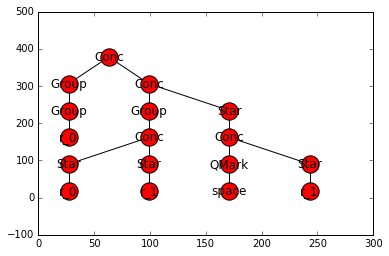

(?:(?:[A-Z]))(?:(?:[A-Z])*(?:[a-z])*)(?:(?: )?(?:[a-z])*)* (14.21717512169558, 4.223966776950649, 60)


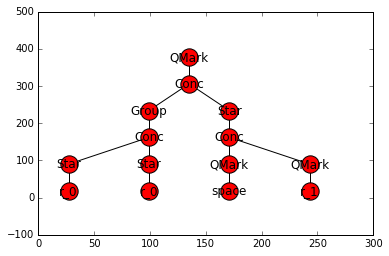

(?:(?:(?:[A-Z])*(?:[A-Z])*)(?:(?: )?(?:[a-z])?)*)? (14.21717512169558, 8.506901386201047, 52)


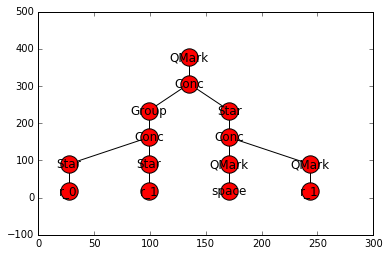

(?:(?:(?:[A-Z])*(?:[a-z])*)(?:(?: )?(?:[a-z])?)*)? (14.21717512169558, 8.506901386201047, 52)


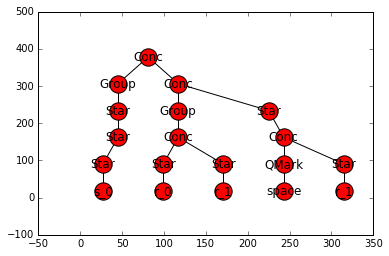

(?:(?:(?:(?:!)*)*)*)(?:(?:[A-Z])*(?:[a-z])*)(?:(?: )?(?:[a-z])*)* (14.21717512169558, 11.256901386201047, 67)


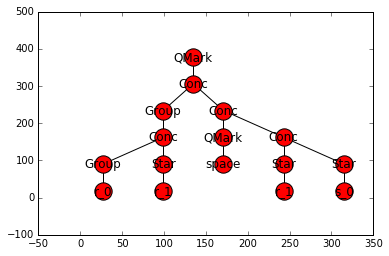

(?:(?:(?:[A-Z])(?:[a-z])*)(?: )?(?:[a-z])*(?:!)*)? (9.925090731944952, 2.7620718290073127, 52)


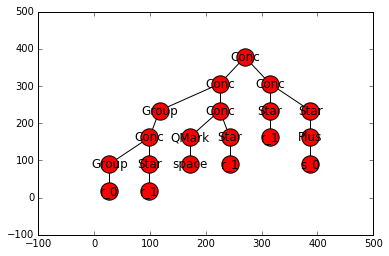

(?:(?:[A-Z])(?:[a-z])*)(?: )?(?:[a-z])*(?:[a-z])*(?:(?:!)+)* (9.925090731944952, 2.7620718290073127, 62)


In [21]:
for item in hof.items:
        tree = gp.PrimitiveTree(item)
    draw_tree(tree)
    print gp.compile(tree, pset).regex, toolbox.evaluate(tree)